In [1]:
import sys; sys.path.append("../../wwa"); from wwa import *

mapproj = cartopy.crs.AlbersEqualArea(central_longitude = 1.0, central_latitude = 47.0)
sf = gpd.read_file("sf_fennoscandia").set_crs("epsg:4326")

Xn,Xx,Yn,Yx = [0,31.9,54,73]

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/FS_heat/"

# Event maps

## Get anomaly fields

In [2]:
for varnm in ["tmax", "tmin"]:

    # load gridded data
    da = wrap_lon(xr.open_dataset(fpath+"era5_"+varnm+"_daily_land_0-40E_50-75N.nc")[varnm])
    
    # load time series & get range of dates
    ts = pd.read_csv("data/t"+varnm[-1]+"-fs-daily_era5.csv", index_col = "time", parse_dates = ["time"]).to_xarray()[varnm]
    end_date = ts.rolling(time = 14).mean().idxmax()
    start_date = end_date.dt.date - timedelta(days = 13)
    date_range = start_date.values.tolist().strftime("%d %B")+" - "+end_date.dt.strftime("%d %B").values
    
    ev = da.sel(time = slice(start_date, end_date)).mean("time")
    clim = da.groupby("time.month")[7].sel(time = slice("1990","2020")).mean("time")
    anom = ev - clim
    
    ds = xr.merge([ev.rename("hw_2025"), clim.rename("clim_9020"), anom.rename("anom_2025")])
    ds = ds.assign_attrs(date_range = date_range)
    ds.to_netcdf("data/event-data_t"+varnm[-1]+"14x_era5.nc")

## Make maps

In [17]:
tx14x, tn14x = [wrap_lon(xr.open_dataset("data/event-data_t"+varnm[-1]+"14x_era5.nc")) for varnm in ["tmax", "tmin"]]

# get projected coordinates for plotting
x,y = project_latlon(tx14x.hw_2025, to_crs = mapproj)

titles = ["Average daily maximum", "Average nightly minimum"]

/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


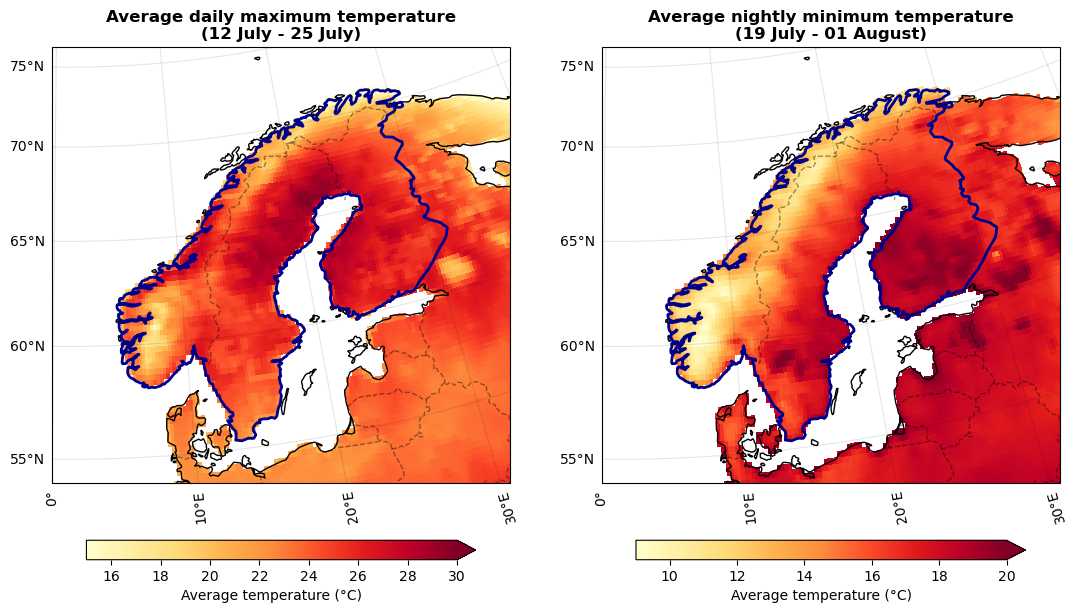

In [19]:
Xn,Xx,Yn,Yx = [0,31.9,54,73]

fig, axs = plt.subplots(ncols = 2, subplot_kw = {"projection" : mapproj, "extent" : (Xn,Xx,Yn,Yx)}, figsize = (13,7.5), dpi = 100)
plt.subplots_adjust(hspace = 0.01)

for i in range(2):
    ax = axs[i]
    ds = [tx14x, tn14x][i]
    
    da = ds.hw_2025
    date_range = ds.date_range
    
    vrange = [{"vmin" : 15, "vmax" : 30}, {"vmin" : 9, "vmax" : 20}][i]
    
    cbar = ax.pcolormesh(x,y, da, cmap = "YlOrRd", **vrange)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.4, ls = "--")
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])
    plt.colorbar(cbar, ax = ax, location = "bottom", shrink = 0.85, pad = 0.1, fraction = 0.1, label = "Average temperature (°C)", extend = "max")
    ax.set_title(titles[i]+" temperature\n("+date_range+")", fontweight = "bold")
    sf.to_crs(mapproj).boundary.plot(ax = ax, color = "darkblue", lw = 2)

plt.savefig("fig/event-map.png")

# Synthesis plots

In [98]:
def synth_plot(df, ax = None, logged = False, split_uw = False):
    
    # set split_uw = True to plot the unweighted mean of obs and models on its own line
    if not ax: fig, ax = plt.subplots(dpi = 100)
    
    gcols = {"obs" : "blue", 
             "obs_synth" : "blue", 
             "models" : "red", 
             "model_synth" : "red",
             "synth" : "magenta",
             "synth_uw" : "lightgrey"}
    
    ylabels = df.model.to_list()
    
    ax.grid(axis = "x", which = "major", color = "k", alpha = 0.1)
    
    if logged:
        ax.set_xscale('log')
        ax.axvline(1, ls = "--", color = "k", zorder = -99)
    else:
        ax.axvline(0, ls = "--", color = "k", zorder = -99)
    
    for k in range(len(df)):

        r = df.iloc[k]
        ax.add_patch(Rectangle((r.lower,-k-0.4), r.upper - r.lower, 0.8, facecolor = gcols[r.name], alpha = 0.5 + 0.5*("synth" in r.name)))
        ax.plot(r.est, -k, color = "k", marker = "v")
        ax.add_patch(Rectangle((r.l_wb,-k-0.4), r.u_wb - r.l_wb, 0.8, edgecolor = "k", facecolor = "none", lw = 1.5))

    ax.set_yticks(range(0, -len(ylabels), -1))
    ax.set_yticklabels(ylabels)

In [ ]:
varnm = "tn14x"
models = "cmip6+cordex"
obs = "_era-eobs"

In [ ]:
gcols = {"obs" : "blue", 
             "obs_synth" : "blue", 
             "models" : "red", 
             "model_synth" : "red",
             "synth" : "magenta",
             "synth_uw" : "lightgrey"}

In [ ]:
synth_attr_dI = pd.read_csv("synthesis/synth_dI-attr_"+varnm+"_"+models+obs+".csv", index_col = "group")
synth_attr_PR = pd.read_csv("synthesis/synth_PR-attr_"+varnm+"_"+models+obs+".csv", index_col = "group")

fig, axs = plt.subplots(ncols = 2, sharey = True, figsize = (10,len(synth_attr_dI)*0.25))
plt.subplots_adjust(hspace = 0.01)

synth_plot(synth_attr_dI, ax = axs[0])
axs[0].set_title("Change in intensity")

synth_plot(synth_attr_PR, ax = axs[1], logged = True)
axs[1].set_title("Probability ratio")
# plt.suptitle("Synthesised changes in "+varnm+" ("+{"attr" : "Past-present", "proj" : "Present-future"}[period]+")")

plt.savefig("fig/synth-plot_attr_"+varnm+"_"+models+obs)

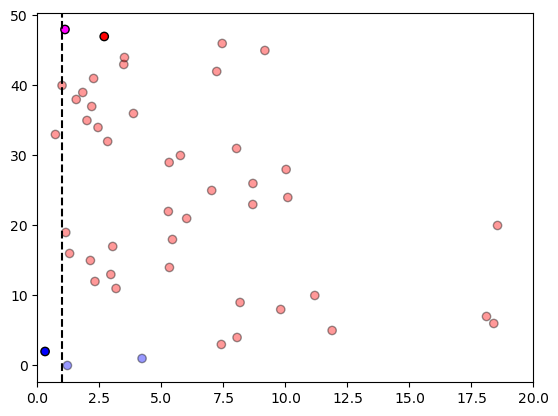

In [140]:
plt.scatter(synth_attr_PR.lower,range(len(synth_attr_PR)), c = [{"obs" : "blue", "model" : "red", "synth" : "magenta"}[c.split("_")[0][:5]] for c in synth_attr_PR.index], 
            alpha = [1 if "synth" in c else 0.4 for c in synth_attr_PR.index], ec = "k")
plt.xlim(0,20)
plt.axvline(1, ls = "--", color = "k")

(0.0, 20.0)

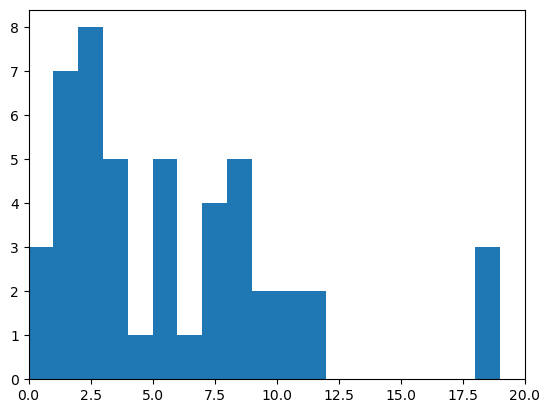

In [139]:
plt.hist(synth_attr_PR.lower, bins = range(0,130))
plt.xlim(0,20)

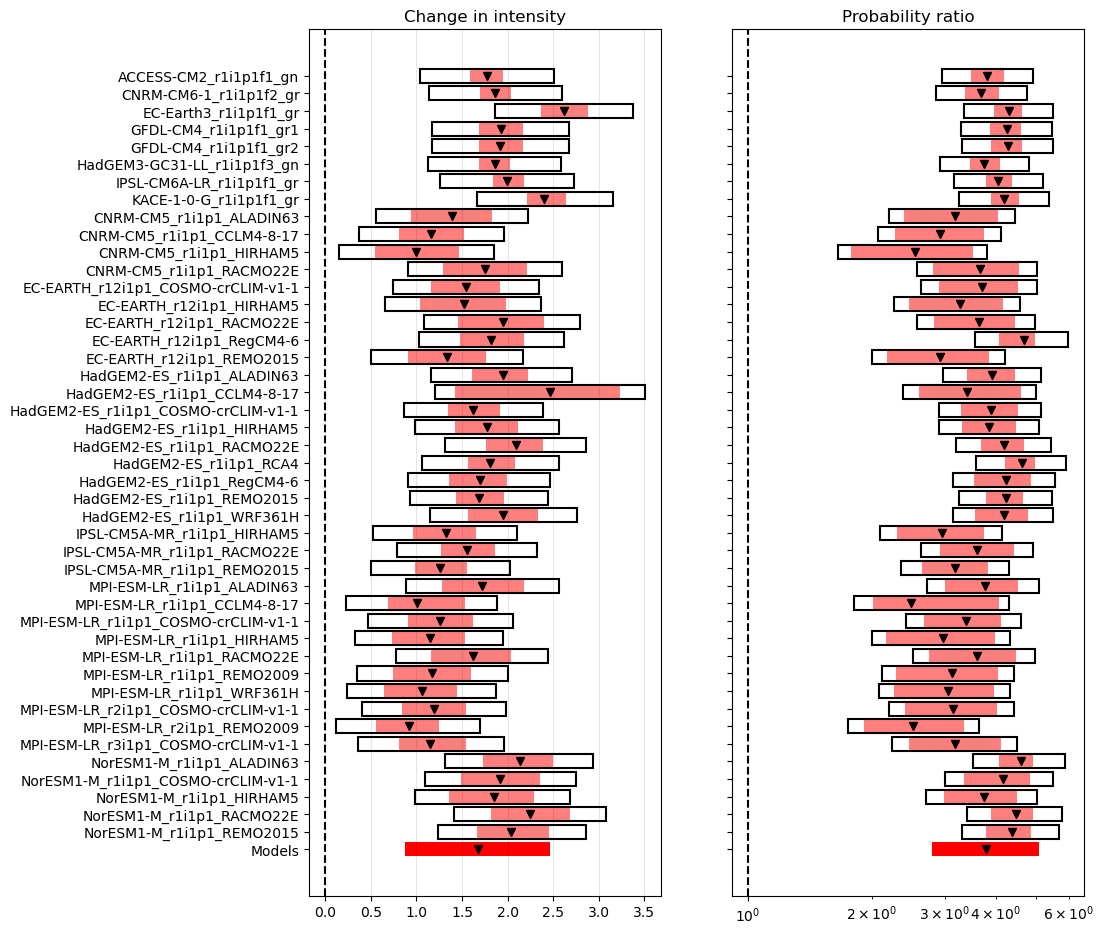

In [54]:
synth_attr_dI = pd.read_csv("synthesis/synth_dI-proj_"+varnm+"_"+models+".csv", index_col = "group")
synth_attr_PR = pd.read_csv("synthesis/synth_PR-proj_"+varnm+"_"+models+".csv", index_col = "group")

xlim_pr = {"tx14x-attr" : (10e-4, 10e20)}

fig, axs = plt.subplots(ncols = 2, sharey = True, figsize = (10,len(synth_attr_dI)*0.25))
plt.subplots_adjust(hspace = 0.1)

synth_plot(synth_attr_dI, ax = axs[0])
axs[0].set_title("Change in intensity")

synth_plot(synth_attr_PR, ax = axs[1], logged = True)
axs[1].set_title("Probability ratio")
# plt.suptitle("Synthesised changes in "+varnm+" ("+{"attr" : "Past-present", "proj" : "Present-future"}[period]+")")

if varnm+"-"+period in xlim_pr.keys():
    axs[1].set_xlim(xlim_pr[varnm+"-"+period])

plt.savefig("fig/synth-plot_proj_"+varnm+"_"+models)